# Using National Map Data 

## Coastline Identification

In order to be able to prune the network (remove subgraphs that don't go anywhere), we'll need to identify the deadend nodes that are on the coast.

1. Reproject `hydrakm010g Coastline` to epsg 3338 shapefile `NatMapCoastline3338.shp`.
2. Select the row containing line segments of 20 miles or more and save as `NatMapCoastline3338gt20.shp`. This looks like it gets all the mainland coast we're interested in and all the sizeable islands, but it lets us ignore the hundreds of small islands and rocks we're not likely to be interested in.
3. Buffer that coastline by 1.5 m. Save as `NatMapCoastBuffer.shp`.
4. Identify graph edges (deadends).
5. Identify edges that intersect buffer. Those are coastal nodes.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import geopandas as gpd
from shapely.geometry import Point

In [3]:
cd /Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance/

/Users/jkibele/Documents/SASAP/sasap-size-declines/RiverDistance


## Buffer the Coastline

Maybe I should read straight from the GDB to eliminate one step?

In [4]:
coastline = gpd.read_file('data/NatMapCoastline3338.shp')

In [5]:
coastline.columns

Index([u'OBJECTID', u'Coastln010', u'Miles', u'SHAPE_Leng', u'geometry'], dtype='object')

In [6]:
%%time
cbuff = coastline.query('Miles > 20.0').buffer(1.5)

CPU times: user 1.39 s, sys: 20.4 ms, total: 1.41 s
Wall time: 1.41 s


In [7]:
%%time
cbuff_u = cbuff.unary_union

CPU times: user 12.5 s, sys: 192 ms, total: 12.7 s
Wall time: 12.7 s


Test it out with a couple of coordinates pulled from QGIS

In [8]:
tpnt = Point( -336954.47, 1580480.52 )
fpnt = Point( -336956.47, 1580480.52 )

In [9]:
cbuff_u.contains(tpnt), cbuff_u.contains(fpnt)

(True, False)

## Find the Deadends

In [13]:
import pyriv
import networkx as nx

In [29]:
%%time
natmap_fn = 'data/usgs_national_map/NatMapStreams3338.shp'
gb = pyriv.GraphBuilder(natmap_fn)

CPU times: user 44 s, sys: 760 ms, total: 44.8 s
Wall time: 44.4 s


In [33]:
len(gb.graph)

0

Uh, WTF? This has happened to me before. I created that file using "Save As" from QGIS to reproject into 3338 from the original geodatabase (in epsg 4269). ...then the file won't produce a graph when imported into networkx. But when I just open it in geopandas and save it out:

In [35]:
nmdf = gpd.read_file(natmap_fn)

In [37]:
newnatmap_fn = 'data/NatMapGDF.shp'
nmdf.to_file(newnatmap_fn)

In [38]:
gb = pyriv.GraphBuilder('data/NatMapGDF.shp')

In [39]:
len(gb.graph)

418120

...then it magically works. Very weird. This argues for either figuring out what's going on or, more easily, just including geopandas in the workflow.

In [40]:
rg = gb.graph #just so I don't have to type as much

To find the "deadends", I'm going to use `networkx.attracting_components`. I think (but I'm not entirely sure) that in the context of a river system, the attracting components can only be river mouths or the type of interior deadend mistakes that we want to eliminate when we prune the graph. [The documentation](http://networkx.readthedocs.io/en/stable/reference/generated/networkx.algorithms.components.attracting.attracting_component_subgraphs.html#networkx.algorithms.components.attracting.attracting_component_subgraphs) is a little ambiguous, but I think the returns will always be individual nodes. ...and that's borne out by this example.

In [72]:
atpnts = [Point(ac) for ac in nx.attracting_components(rg)]
len(atpnts)

2262

In [73]:
atdf = gpd.GeoDataFrame({'geometry': atpnts})

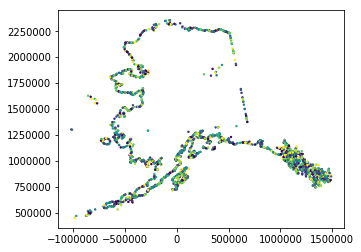

In [74]:
atdf.plot()

## Subset for the Kuskokwim

This will make development a bit easier.

In [97]:
regions = gpd.read_file('/Users/jkibele/Documents/SASAP/gis/data_sasap/Regions Shapefile/sasap_regions_3338.shp')

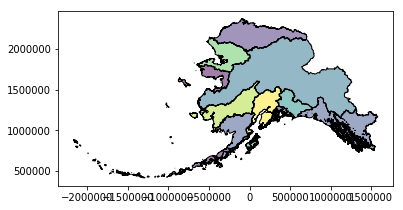

In [98]:
regions.plot()

In [100]:
kusko = regions[regions.SASAP_Regi == "Kuskokwim"]

In [113]:
%%time
kuskbuff = kusko.geometry.buffer(3000.0, 8)

CPU times: user 27.9 s, sys: 845 ms, total: 28.8 s
Wall time: 28.9 s


In [145]:
kbs = kuskbuff.simplify(100.0).unary_union

In [167]:
%%time
kc_ind = cbuff.intersects(kbs)

CPU times: user 659 ms, sys: 26.3 ms, total: 685 ms
Wall time: 702 ms


In [168]:
kc_ind.sum()

6

In [169]:
kuskocoast = cbuff[kc_ind]

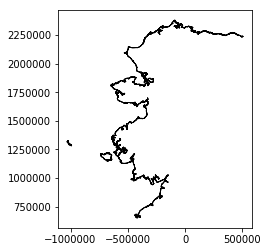

In [170]:
kuskocoast.plot()

In [124]:
%%time
kuskcoast_ind = coastline.centroid.within(kbs)

CPU times: user 39 ms, sys: 6.32 ms, total: 45.3 ms
Wall time: 51.2 ms


In [138]:
%%time
kc_ind = coastline.overlaps(kusko)

CPU times: user 12.5 ms, sys: 2.49 ms, total: 15 ms
Wall time: 13 ms


Actually, I think it's easier to subset the streams by reach code than geographically.

In [104]:
hucs = ['190304','190305']
# convert to str in case it's numeric
kusko_huc = lambda s: str(s)[:6] in hucs

In [109]:
nmdf[nmdf.ReachCode.apply(kusko_huc)].to_file('data/NatMapKuskoStreams.shp')

In [110]:
kuskgb = pyriv.GraphBuilder('data/NatMapKuskoStreams.shp')

In [111]:
krg = kuskgb.graph

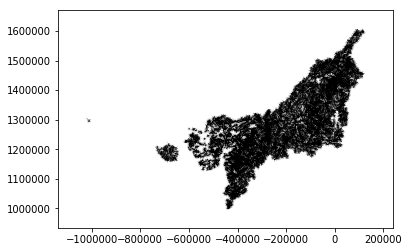

In [112]:
krg.plot()

In [171]:
type(krg.nodes())

list

## Find the Deadends

In [220]:
def deadends_loop(self):
    """
    This is slower. Don't use it. Use the next one.
    """
    nlist = self.nodes()
    deadlist = []
    for n in nlist:
        if self.out_degree(n) == 0:
            deadlist.append(n)
    return deadlist

In [221]:
def deadends(self):
    """
    For a directed graph, find the nodes that have in edges but no out edges.
    """
    # get a dictionary of { node: out_degree }
    degdict = self.out_degree(self.nodes())
    # convert to a 2 column array of node and out_degree
    degarr = np.array(degdict.items())
    # get a boolean index of rows where out_degree==0
    dead_row_ind = (degarr[:,1]==0)
    # use that index to get the nodes
    dead_nodes = degarr[:,0][dead_row_ind]
    return tuple(dead_nodes)

In [222]:
%%time
dlist = deadends_loop(krg)

CPU times: user 295 ms, sys: 48.2 ms, total: 343 ms
Wall time: 308 ms


In [223]:
len(dlist)

127

Create a tuple full of all the deadend nodes, both coastal and inland.

In [224]:
%%time
dnodes = deadends(krg)

CPU times: user 175 ms, sys: 31.5 ms, total: 206 ms
Wall time: 183 ms


Use a list comprehension to convert that tuple of nodes into a list of point geometries using `shapely.geometry.Point`, and turn it into a geodataframe. GeoDataFrame constructor can take a dictionary. Keys are column names and iterable values get turned into series objects. The `crs` property is how you set the projection. EPSG 3338 is Alaska Albers.

In [244]:
kcdf = gpd.GeoDataFrame({'geometry': [Point(n) for n in dnodes]})
kcdf.crs = {'init': 'epsg:3338'}

This creates a column `('coastal')`, that will get turned into a shapefile field when exported. That can be used to visualize which points are which.

In [245]:
%%time
kcdf['coastal'] = kcdf.within(kuskocoast.unary_union)

CPU times: user 9.27 s, sys: 122 ms, total: 9.39 s
Wall time: 9.4 s


In [247]:
kcdf[kcdf.coastal]

,geometry,coastal
0,POINT (-441276.1955439668 1074954.89468615),True
1,POINT (-571544.6418256944 1220373.691349238),True
2,POINT (-710453.615738384 1173727.412915865),True
3,POINT (-693783.5774765555 1162979.349257292),True
4,POINT (-575822.055803597 1177147.328786778),True
5,POINT (-519558.548452016 1219509.952602171),True
6,POINT (-470949.9732654491 1180907.092965425),True
7,POINT (-599567.5236246133 1215295.8105572),True
8,POINT (-695579.0352541491 1212029.915463886),True
9,POINT (-674156.0440627867 1158161.920271574),True


## Find the Subset of Deadends on the Coast

This is for the full statewide data set. It takes about 30 minutes on my laptop.

In [77]:
%%time
coastal_ind = atdf.within(cbuff_u)

CPU times: user 30min 52s, sys: 1min 35s, total: 32min 28s
Wall time: 16h 6min 17s


In [79]:
coastal_ind.sum()

2185

In [80]:
(~coastal_ind).sum()

77

In [86]:
atdf['coastal'] = coastal_ind.astype('int')

In [87]:
atdf.crs = nmdf.crs

In [88]:
atdf.to_file('data/coastal_nodes.shp')

All of Alaska:

In [3]:
%%time
gb = GraphBuilder('data/usgs_national_map/NatMapStreams3338.shp')

CPU times: user 41.9 s, sys: 835 ms, total: 42.7 s
Wall time: 42.3 s


In [4]:
rg = gb.graph

In [94]:
sc = [g for g in nx.strongly_connected_components(rg)]

In [95]:
len(sc)

418120

In [96]:
len(rg.nodes())

418120

In [3]:
pos0 = (-320315, 1284942)
pos1 = (-463112, 1167822)

In [6]:
rg.closest_node(pos0)

ValueError: operands could not be broadcast together with shapes (0,) (2,) 

In [7]:
narr = np.array(rg.nodes())

In [8]:
narr

array([], dtype=float64)

In [5]:
import networkx as nx

In [10]:
nrg = nx.read_shp('data/usgs_national_map/NatMapStreams3338.shp')

In [15]:
len(nrg.edges())

0

In [6]:
import geopandas as gpd